## FRAUD DETECTION on ONLINE TRANSACTIONS

### Project Overview

### Project Steps

1. Loading Data and EDA
2. Feature Engineering
3. Machine Learning
   - 3.1 Baseline Models
   - 3.2 Grid Search for Best Hyper-parameter
   - 3.3 Dealing with Unbalanced Data
     - 3.3.1 Balancing Data via Resampling with SMOTE
     - 3.3.2 Subsampling Data from the Original Dataset
     - 3.3.3 Performing SMOTE on the New Data
4. Machine Learning Pipeline
5. Feature Importance
6. Conclusion



## 1. Loading Data and EDA :-

In [1]:
import os
import math
from numpy import * 
import numpy as np
import pandas as pd
import random
import seaborn as sns #for visualization
import matplotlib.pyplot as plt #for visualization

In [2]:
#Load data 
data=pd.read_csv('Fraud.csv')
data.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [3]:
#check the shape of the dataset
data.shape

(6362620, 11)

In [4]:
#examine the dataset
data.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00


In [5]:
#Check if there is any null values
data.isna().sum().sum()

0

In [6]:
#check for duplicate values
data.duplicated(keep='first').any()

False

## Distribution of all Transactions

In [10]:
# Filter data by the labels. Safe and Fraud transaction
safe = data[data['isFraud']==0]
fraud = data[data['isFraud']==1]

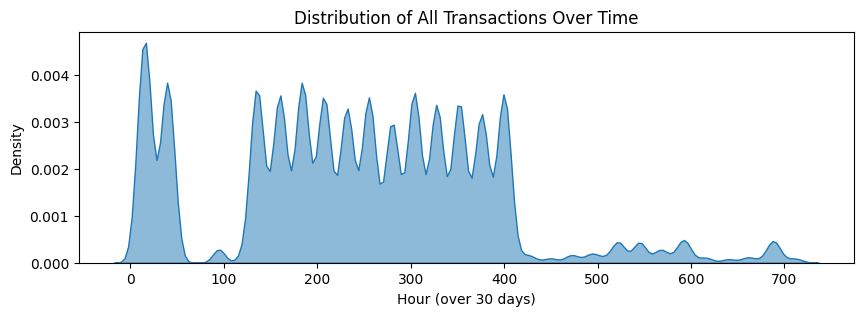

In [11]:
# Distribution of the frequency of all transactions
plt.figure(figsize=(10, 3))

# Use the modern histplot function with a density curve
sns.kdeplot(data=safe, x='step', label='Safe Transaction', fill=True, alpha=0.5)

plt.title('Distribution of All Transactions Over Time')
plt.xlabel('Hour (over 30 days)')
plt.ylabel('Density')
plt.show()

It shows number of transactions occured each hour (step)

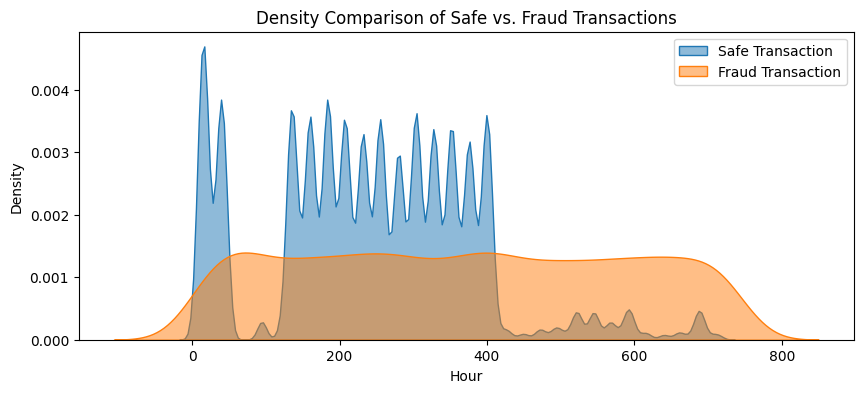

In [12]:
# Create a plot using Kernel Density Estimates
plt.figure(figsize=(10, 4))

# Plot the KDE for both safe and fraud transactions
sns.kdeplot(data=safe, x='step', label='Safe Transaction', fill=True, alpha=0.5)
sns.kdeplot(data=fraud, x='step', label='Fraud Transaction', fill=True, alpha=0.5)

plt.title('Density Comparison of Safe vs. Fraud Transactions')
plt.xlabel('Hour')
plt.ylabel('Density')
plt.legend()
plt.show()

### Hourly Transaction Amounts

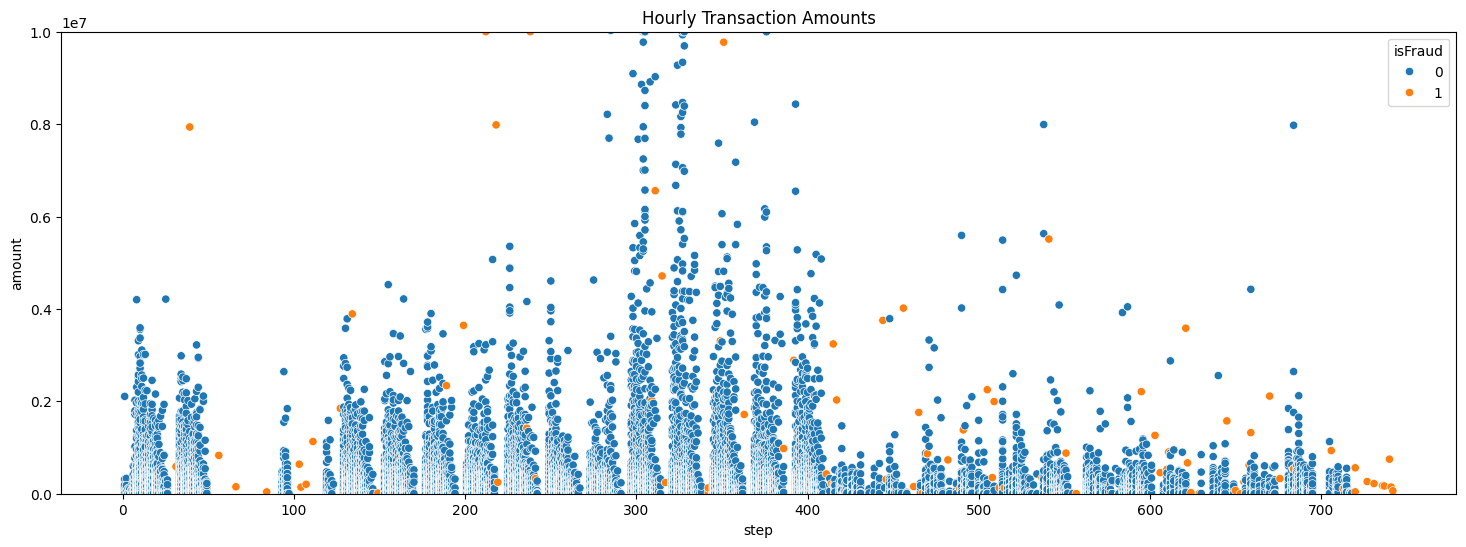

In [13]:
#just use small portion of data to scatterplot the transaction happens every hour and their amount. 
smalldata=data.sample(n=100000, random_state=1)
smalldata=smalldata.sort_index()
smalldata=smalldata.reset_index(drop=True)

#plot the small data
plt.figure(figsize=(18,6))
plt.ylim(0, 10000000)
plt.title('Hourly Transaction Amounts')
ax = sns.scatterplot(x="step", y="amount", hue="isFraud",
                     data=smalldata)

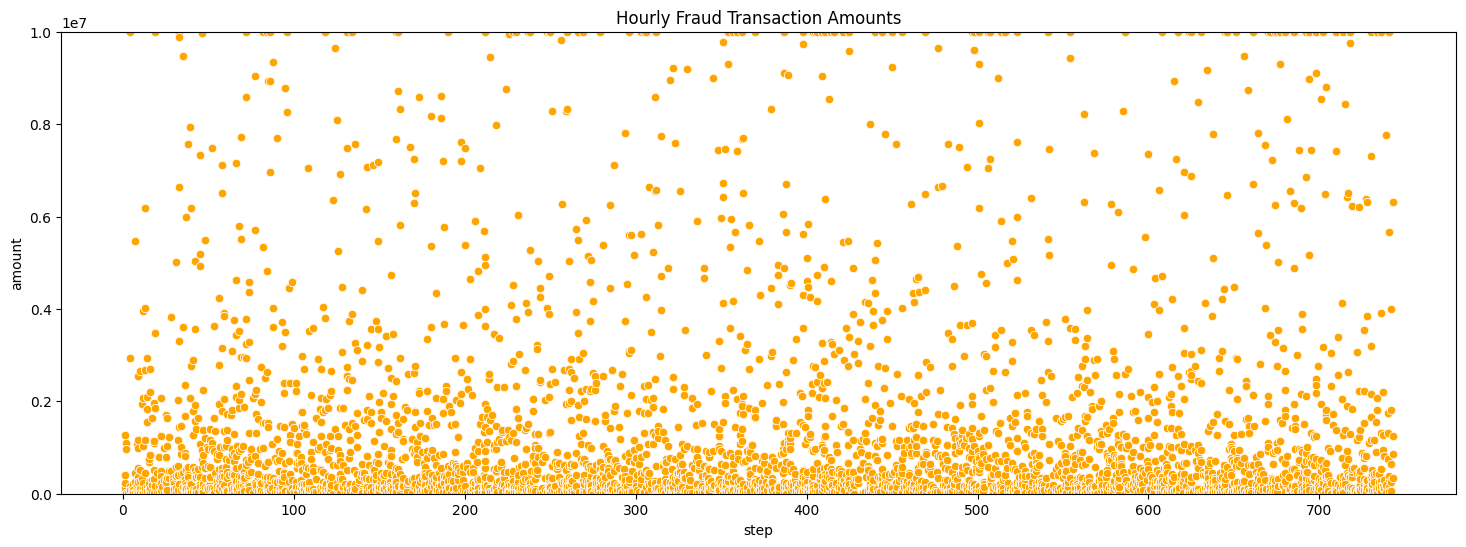

In [14]:
#The hourly amount of al fraud transactions
plt.figure(figsize=(18,6))
plt.ylim(0, 10000000)
plt.title('Hourly Fraud Transaction Amounts')
ax = sns.scatterplot(x="step", y="amount", color='orange',
                     data=fraud)

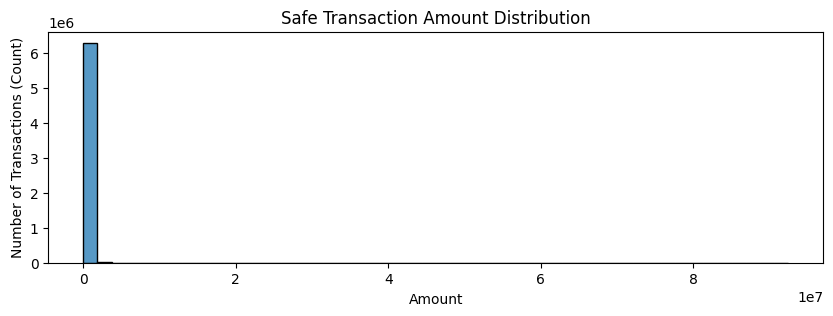

In [15]:
plt.figure(figsize=(10, 3))

# Use histplot and set density=False to show counts (not probability density)
sns.histplot(data=safe, x='amount', bins=50, kde=False)

plt.title('Safe Transaction Amount Distribution')
plt.xlabel('Amount')
plt.ylabel('Number of Transactions (Count)')

# Let matplotlib automatically choose y-axis ticks that match the counts
plt.ylim(0, None)  # start from 0, auto-scale top

plt.show()

In [16]:
safe.amount.describe()

count    6.354407e+06
mean     1.781970e+05
std      5.962370e+05
min      1.000000e-02
25%      1.336840e+04
50%      7.468472e+04
75%      2.083648e+05
max      9.244552e+07
Name: amount, dtype: float64

C:\Users\KIIT0001\AppData\Local\Temp\ipykernel_34100\2360975852.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(fraud.amount)


<Axes: title={'center': 'Fraud Transaction Amount Distribution'}, xlabel='amount', ylabel='Density'>

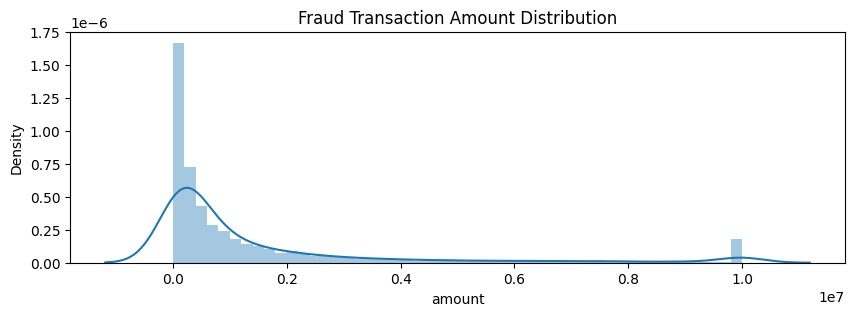

In [17]:
# Fraud transactions amount distribution plot
plt.figure(figsize=(10,3))
plt.title('Fraud Transaction Amount Distribution')
sns.distplot(fraud.amount)

In [18]:
# fraud transactions amount value counts
fraud.amount.value_counts()

amount
10000000.00    287
0.00            16
1165187.89       4
429257.45        4
181.00           2
              ... 
149668.66        1
7316255.05       1
222048.71        1
9585040.37       1
234377.29        1
Name: count, Length: 3977, dtype: int64

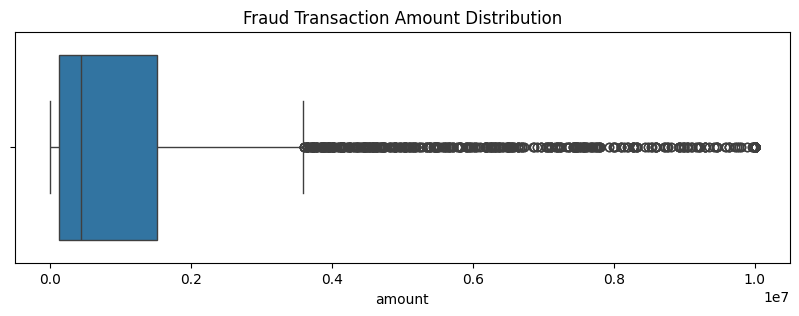

In [19]:
#Fraud transaction boxplot for amount distribution
plt.figure(figsize=(10,3))
plt.title('Fraud Transaction Amount Distribution')
ax = sns.boxplot(x=fraud["amount"])

In [20]:
fraud.amount.describe()

count    8.213000e+03
mean     1.467967e+06
std      2.404253e+06
min      0.000000e+00
25%      1.270913e+05
50%      4.414234e+05
75%      1.517771e+06
max      1.000000e+07
Name: amount, dtype: float64

In [21]:
#average amount for frauds below 400K
fraud[fraud.amount<400000].amount.mean()

144912.1682893401

In [22]:
#checking "0" in the fraud  amount
fraud[fraud.amount==0]

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
2736447,212,CASH_OUT,0.0,C1510987794,0.0,0.0,C1696624817,0.00,0.00,1,0
3247298,250,CASH_OUT,0.0,C521393327,0.0,0.0,C480398193,0.00,0.00,1,0
3760289,279,CASH_OUT,0.0,C539112012,0.0,0.0,C1106468520,538547.63,538547.63,1,0
5563714,387,CASH_OUT,0.0,C1294472700,0.0,0.0,C1325541393,7970766.57,7970766.57,1,0
5996408,425,CASH_OUT,0.0,C832555372,0.0,0.0,C1462759334,76759.90,76759.90,1,0
5996410,425,CASH_OUT,0.0,C69493310,0.0,0.0,C719711728,2921531.34,2921531.34,1,0
6168500,554,CASH_OUT,0.0,C10965156,0.0,0.0,C1493336195,230289.66,230289.66,1,0
6205440,586,CASH_OUT,0.0,C1303719003,0.0,0.0,C900608348,1328472.86,1328472.86,1,0
6266414,617,CASH_OUT,0.0,C1971175979,0.0,0.0,C1352345416,0.00,0.00,1,0
6281483,646,CASH_OUT,0.0,C2060908932,0.0,0.0,C1587892888,0.00,0.00,1,0


### Type of Transactions

In [23]:
#checking type of  safe transactions
safe.type.value_counts()

type
CASH_OUT    2233384
PAYMENT     2151495
CASH_IN     1399284
TRANSFER     528812
DEBIT         41432
Name: count, dtype: int64

In [24]:
#checking type of fraud transactions
fraud.type.value_counts()

type
CASH_OUT    4116
TRANSFER    4097
Name: count, dtype: int64

### Rate of Fraud Transactions

In [25]:
#proportion of number of frauds 
data.isFraud.value_counts()[1]/(data.isFraud.value_counts()[0]+data.isFraud.value_counts()[1])

0.001290820448180152

In [26]:
#proportion of fraud amount
fraud.amount.sum()/(safe.amount.sum()+fraud.amount.sum())

0.010535206008606473

Total money was stolen is 0.1% of safe transaction amount.

### isFlaggedFraud column

In [27]:
#value counts of isFlaggedFraud column
data.isFlaggedFraud.value_counts()

isFlaggedFraud
0    6362604
1         16
Name: count, dtype: int64

In [28]:
#there are only 16 positive value. lets see which ones they are. 
data[data.isFlaggedFraud==1]

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
2736446,212,TRANSFER,4953893.08,C728984460,4953893.08,4953893.08,C639921569,0.0,0.0,1,1
3247297,250,TRANSFER,1343002.08,C1100582606,1343002.08,1343002.08,C1147517658,0.0,0.0,1,1
3760288,279,TRANSFER,536624.41,C1035541766,536624.41,536624.41,C1100697970,0.0,0.0,1,1
5563713,387,TRANSFER,4892193.09,C908544136,4892193.09,4892193.09,C891140444,0.0,0.0,1,1
5996407,425,TRANSFER,10000000.00,C689608084,19585040.37,19585040.37,C1392803603,0.0,0.0,1,1
5996409,425,TRANSFER,9585040.37,C452586515,19585040.37,19585040.37,C1109166882,0.0,0.0,1,1
6168499,554,TRANSFER,3576297.10,C193696150,3576297.10,3576297.10,C484597480,0.0,0.0,1,1
6205439,586,TRANSFER,353874.22,C1684585475,353874.22,353874.22,C1770418982,0.0,0.0,1,1
6266413,617,TRANSFER,2542664.27,C786455622,2542664.27,2542664.27,C661958277,0.0,0.0,1,1
6281482,646,TRANSFER,10000000.00,C19004745,10399045.08,10399045.08,C1806199534,0.0,0.0,1,1


All flagged cases are also fraud, with balance inconsistencies that may explain the flag. I’ll keep this as valuable information.

## 2. Feature Engineering :-

First only get Transfer and Cash_out transaction data

In [29]:
#filtering only transfer and cash_out data
data_by_type=data[data['type'].isin(['TRANSFER','CASH_OUT'])]

### Get 100000 random samples from the filtered data

In [30]:
#subsample data , get 100000 instances to train model
df=data_by_type.sample(n=100000, random_state=1)
df=df.sort_index()
df=df.reset_index(drop=True)
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,CASH_OUT,136872.92,C1533123860,162075.98,25203.05,C766572210,217806.00,0.00,0,0
1,1,TRANSFER,367768.40,C288306765,0.00,0.00,C1359044626,370763.10,16518.36,0,0
2,1,CASH_OUT,81029.86,C324112183,0.00,0.00,C288665596,105343.00,8496.61,0,0
3,1,CASH_OUT,53631.83,C1233595751,0.00,0.00,C757108857,83244.00,0.00,0,0
4,1,CASH_OUT,365510.05,C1299327689,0.00,0.00,C564160838,564572.76,1254956.07,0,0


nameOrig and nameDest columns are supposed to be the names of the peeople. At this moment, they can not be used in machine learning model. But if there is any repeting transaction between two people that might me useful information for classifier.I can create a new column with numeric value with repeat info. Let me check.

In [31]:
#checking if there is any repetes transaction in between two parties.
list1=np.array(df.nameOrig)
list2=np.array(df.nameDest)
list3=list1+list2
repeat=pd.DataFrame(list3, columns=['comb'])
comb_cnt=repeat.comb.value_counts()
comb_cnt.value_counts()

count
1    100000
Name: count, dtype: int64

### Binary encoding the type column

In [32]:
#drop the name columns
df=df.drop(['nameOrig', 'nameDest'], axis=1)
#Binary-encoding of labelled data in 'type'
df.loc[df.type == 'CASH_OUT', 'type'] = 1
df.loc[df.type == 'TRANSFER', 'type'] = 0
df.head()

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,1,136872.92,162075.98,25203.05,217806.00,0.00,0,0
1,1,0,367768.40,0.00,0.00,370763.10,16518.36,0,0
2,1,1,81029.86,0.00,0.00,105343.00,8496.61,0,0
3,1,1,53631.83,0.00,0.00,83244.00,0.00,0,0
4,1,1,365510.05,0.00,0.00,564572.76,1254956.07,0,0


## 3. ML PART :-

In [33]:
from sklearn.model_selection import train_test_split # import train_test_split function
from sklearn.linear_model import LogisticRegression # import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score # import accuracy metrics
from sklearn.ensemble import RandomForestClassifier #import RandomForestClassifier
from sklearn import svm  #import support vector machine classifier
import xgboost as xgb  
from xgboost import  XGBClassifier  #import xgboost classifier 
from sklearn.neighbors import KNeighborsClassifier #import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV # import GridSearchCV
# suppress all warnings
import warnings
warnings.filterwarnings("ignore")

In [34]:
#Slice the target and features from the dataset
features=df.drop('isFraud', axis=1)
target =df.isFraud

# split the data into train and test
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2)

### 3.1. Baseline Models

I will first run five classification models — Logistic Regression, KNN, Random Forest, XGBoost, and SVM  with default parameters to establish a baseline. A single function, ml_func, handles training, prediction, and evaluation. Since fraud cases are only 0.01% of transactions, standard accuracy is not meaningful, so I will use metrics like ROC-AUC or AUPRC to fairly assess the models’ ability to detect fraud.

In [41]:
# Make 'type' column categorical for XGBClassifier
X_train['type'] = X_train['type'].astype('category')
X_test['type']  = X_test['type'].astype('category')


In [42]:
# Store results for all models
all_scores = []


In [43]:
from sklearn.metrics import roc_auc_score

def ml_func(algoritm):
    # Handle XGBClassifier and SVM special cases
    if algoritm == XGBClassifier:
        model = algoritm(enable_categorical=True)
    elif algoritm == svm.SVC:
        model = algoritm(probability=True)
    else:
        model = algoritm()
    
    # Train model
    model.fit(X_train, y_train)
    
    # Predict probabilities for AUC
    if hasattr(model, "predict_proba"):
        train_preds = model.predict_proba(X_train)[:,1]
        test_preds  = model.predict_proba(X_test)[:,1]
    else:  # fallback for models without predict_proba
        train_preds = model.decision_function(X_train)
        test_preds  = model.decision_function(X_test)
    
    # Evaluate
    train_auc = roc_auc_score(y_train, train_preds)
    test_auc  = roc_auc_score(y_test, test_preds)
    
    # Print results
    print(str(algoritm))
    print("------------------------")
    print(f"Training AUC: {(train_auc * 100):.2f}%")
    print(f"Test AUC:     {(test_auc * 100):.2f}%\n")
    
    # Append to results
    all_scores.append([str(algoritm), train_auc, test_auc])


In [44]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn import svm

algoritms = [LogisticRegression, KNeighborsClassifier, RandomForestClassifier, XGBClassifier, svm.SVC]


In [45]:
for algoritm in algoritms:
    ml_func(algoritm)

# Convert results to DataFrame
models = pd.DataFrame(all_scores, columns=['Model', 'Train AUC', 'Test AUC'])
models


<class 'sklearn.linear_model._logistic.LogisticRegression'>
------------------------
Training AUC: 98.61%
Test AUC:     98.37%

<class 'sklearn.neighbors._classification.KNeighborsClassifier'>
------------------------
Training AUC: 99.95%
Test AUC:     85.76%

<class 'sklearn.ensemble._forest.RandomForestClassifier'>
------------------------
Training AUC: 100.00%
Test AUC:     95.48%

<class 'xgboost.sklearn.XGBClassifier'>
------------------------
Training AUC: 100.00%
Test AUC:     96.97%

<class 'sklearn.svm._classes.SVC'>
------------------------
Training AUC: 93.32%
Test AUC:     90.71%



,Model,Train AUC,Test AUC
0,<class 'sklearn.linear_model._logistic.Logisti...,0.986073,0.983667
1,<class 'sklearn.neighbors._classification.KNei...,0.999537,0.857644
2,<class 'sklearn.ensemble._forest.RandomForestC...,1.000000,0.954773
3,<class 'xgboost.sklearn.XGBClassifier'>,0.999999,0.969727
4,<class 'sklearn.svm._classes.SVC'>,0.933166,0.907107


### 3.2. Grid Search for Best Hyper-Parameter

Random Forest gave the best training accuracy, and XGBoost the best test accuracy. I’ll optimize these two using Grid Search to find the best parameters and focus only on them for the rest of the project.

In [46]:
#A general function for grdi search
def grid_src(classifier, param_grid):
    param_grid=param_grid
    # instantiate the tuned random forest
    grid_search = GridSearchCV(classifier, param_grid, cv=3, n_jobs=-1)

    # train the tuned random forest
    grid_search.fit(X_train, y_train)

    # print best estimator parameters found during the grid search
    print((str(classifier) + 'Best Parameters'))
    print("------------------------")
    print(grid_search.best_params_)
    return grid_search.best_params_

In [47]:
#Grid Search for best parameters of RandomForestClassifier
param_grid_rf = {'n_estimators': [10, 80, 100],
                  'criterion': ['gini', 'entropy'],         
                  'max_depth': [10], 
                  'min_samples_split': [2, 3, 4]
                 }

rf_params=grid_src(RandomForestClassifier(),param_grid_rf)

RandomForestClassifier()Best Parameters
------------------------
{'criterion': 'entropy', 'max_depth': 10, 'min_samples_split': 3, 'n_estimators': 80}


In [ ]:
param_grid_xg = {
    'n_estimators': [100],
    'learning_rate': [0.05, 0.1],
    'max_depth': [3, 5, 10],
    'colsample_bytree': [0.7, 1],
    'gamma': [0.0, 0.1, 0.2]
}

# If your dataset has categorical columns, encode them first OR set enable_categorical=True 
# when using XGBClassifier directly on categorical columns (after encoding as 'category' dtype)
xgb_model = XGBClassifier(enable_categorical=True, use_label_encoder=False, eval_metric='logloss', random_state=0)

# Run grid search for XGBoost
xgb_params = grid_src(xgb_model, param_grid_xg)

### Run models with their best parameters

In [48]:
#a function to train and evaluate a  model with given datasets 
#it also prints the accuracy scores 
def run_model(model, X_train, y_train,X_test, y_test ):
    model.fit(X_train, y_train)

    # predict
    train_preds = model.predict(X_train)
    test_preds = model.predict(X_test)

    # evaluate
    train_accuracy = roc_auc_score(y_train, train_preds)
    test_accuracy = roc_auc_score(y_test, test_preds)
    report = classification_report(y_test, test_preds)

    #print reports of the model accuracy
    print('Model Scores')
    print("------------------------")
    print(f"Training Accuracy: {(train_accuracy * 100):.4}%")
    print(f"Test Accuracy:     {(test_accuracy * 100):.4}%")
    print("------------------------------------------------------")
    print('Classification Report : \n', report)

In [51]:
# Running RandomForestClassifier with best parameters
rf_model=RandomForestClassifier(n_estimators=100, 
                                  criterion= 'gini', 
                                  max_depth= 10, 
                                  min_samples_split= 3)
                               
                               
run_model(rf_model, X_train, y_train,X_test, y_test)

Model Scores
------------------------
Training Accuracy: 86.7%
Test Accuracy:     82.5%
------------------------------------------------------
Classification Report : 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     19940
           1       1.00      0.65      0.79        60

    accuracy                           1.00     20000
   macro avg       1.00      0.82      0.89     20000
weighted avg       1.00      1.00      1.00     20000



### 3.3. Dealing with Unbalanced Data

### 3.3.1. Balancing Data via Oversampling with SMOTE

In [54]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

# view previous class distribution
print(target.value_counts()) 

# resample data ONLY using training data
smote = SMOTE(random_state=0)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)  # use fit_resample()

# view synthetic sample class distribution
print(pd.Series(y_resampled).value_counts())

isFraud
0    99722
1      278
Name: count, dtype: int64
isFraud
0    79782
1    79782
Name: count, dtype: int64


In [55]:
# perform  train-test-split over resampled data
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, random_state=0)

### Running models with the balanced data with best parameters

In [56]:
#Running RainForest Model with resampled data
run_model(rf_model, X_train, y_train,X_test, y_test)

Model Scores
------------------------
Training Accuracy: 98.91%
Test Accuracy:     98.88%
------------------------------------------------------
Classification Report : 
               precision    recall  f1-score   support

           0       0.99      0.99      0.99     19722
           1       0.99      0.99      0.99     20169

    accuracy                           0.99     39891
   macro avg       0.99      0.99      0.99     39891
weighted avg       0.99      0.99      0.99     39891



In [58]:
from xgboost import XGBClassifier

# define the XGBoost model (with categorical support if needed)
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', enable_categorical=True, random_state=0)

# run the model using your function
run_model(xgb_model, X_train, y_train, X_test, y_test)


Model Scores
------------------------
Training Accuracy: 99.95%
Test Accuracy:     99.83%
------------------------------------------------------
Classification Report : 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     19722
           1       1.00      1.00      1.00     20169

    accuracy                           1.00     39891
   macro avg       1.00      1.00      1.00     39891
weighted avg       1.00      1.00      1.00     39891



### 3.3.2. Subsampling Data from the Original Dataset

In [59]:
#Filter the only types that fraud transaction occurs
data2=data[data['type'].isin(['TRANSFER','CASH_OUT'])]
#Slice data in to fraud and safe by isFraud values
safe_2 = data2[data2['isFraud']==0]
fraud_2 = data2[data2['isFraud']==1]
#get 50000 random sample from the safe transactions 
safe_sample=safe_2.sample(n=50000, random_state=1)
safe_sample=safe_sample.sort_index()
safe_samplef=safe_sample.reset_index(drop=True)
#combine all fraud observation and 50000 safe transaction data in to df3
df3=pd.concat([safe_sample,fraud_2])
df3.reset_index(drop=True)
#drop name columns
df3=df3.drop(['nameOrig', 'nameDest'], axis=1)
#Binary-encoding of labelled data in 'type'
df3.loc[df3.type == 'CASH_OUT', 'type'] = 1
df3.loc[df3.type == 'TRANSFER', 'type'] = 0
df3.head()

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
78,1,0,42712.39,10363.39,0.0,57901.66,24044.18,0,0
93,1,0,583848.46,0.00,0.0,667778.00,2107778.11,0,0
159,1,1,154716.20,0.00,0.0,187433.00,3461666.05,0,0
162,1,1,267148.82,0.00,0.0,641975.35,1178808.14,0,0
191,1,1,55105.90,0.00,0.0,317952.89,2719172.89,0,0


In [60]:
#check class labels
df3.isFraud.value_counts()

isFraud
0    50000
1     8213
Name: count, dtype: int64

### Running models with subsampled natural data

In [61]:
#Slide the target and features from the dataset
features2=df3.drop('isFraud', axis=1)
target2 =df3.isFraud
# split the data into train and test
X_train2, X_test2, y_train2, y_test2 = train_test_split(features2, target2, test_size=0.2)

In [62]:
# Running RandomForestClassifier with best parameters
run_model(rf_model, X_train2, y_train2,X_test2, y_test2)

Model Scores
------------------------
Training Accuracy: 93.56%
Test Accuracy:     93.19%
------------------------------------------------------
Classification Report : 
               precision    recall  f1-score   support

           0       0.98      1.00      0.99     10025
           1       0.99      0.87      0.92      1618

    accuracy                           0.98     11643
   macro avg       0.98      0.93      0.96     11643
weighted avg       0.98      0.98      0.98     11643



In [66]:
# Convert all object columns to category
for col in X_train2.select_dtypes(include='object').columns:
    X_train2[col] = X_train2[col].astype('category')
    X_test2[col]  = X_test2[col].astype('category')

# Define XGBoost model
xgb_model = XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    enable_categorical=True,
    random_state=0
)

# Run model
run_model(xgb_model, X_train2, y_train2, X_test2, y_test2)


Model Scores
------------------------
Training Accuracy: 99.87%
Test Accuracy:     99.23%
------------------------------------------------------
Classification Report : 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     10025
           1       0.98      0.99      0.98      1618

    accuracy                           1.00     11643
   macro avg       0.99      0.99      0.99     11643
weighted avg       1.00      1.00      1.00     11643



In [67]:
# Running XGBClassifier with best parameters

run_model(xgb_model, X_train2, y_train2,X_test2, y_test2)

Model Scores
------------------------
Training Accuracy: 99.87%
Test Accuracy:     99.23%
------------------------------------------------------
Classification Report : 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     10025
           1       0.98      0.99      0.98      1618

    accuracy                           1.00     11643
   macro avg       0.99      0.99      0.99     11643
weighted avg       1.00      1.00      1.00     11643



The results now look more realistic, and the XGBoost model consistently performs better across different datasets. Although the data proportion has improved, it’s still imbalanced, so applying SMOTE or oversampling can help increase the representation of fraud cases and potentially improve model performance further.

### 3.3.3 Performing SMOTE on the New Data

In [70]:
from imblearn.over_sampling import SMOTE

# view previous class distribution
print(target2.value_counts()) 

# resample data using training data
X_resampled2, y_resampled2 = SMOTE().fit_resample(X_train2, y_train2) 

# view synthetic sample class distribution
print(pd.Series(y_resampled2).value_counts())


isFraud
0    50000
1     8213
Name: count, dtype: int64
isFraud
0    39975
1    39975
Name: count, dtype: int64


### Running models with subsampled and oversampled data

In [71]:
# Running RandomForestClassifier with best parameters
run_model(rf_model, X_train2, y_train2,X_test2, y_test2)

Model Scores
------------------------
Training Accuracy: 93.39%
Test Accuracy:     92.76%
------------------------------------------------------
Classification Report : 
               precision    recall  f1-score   support

           0       0.98      1.00      0.99     10025
           1       0.99      0.86      0.92      1618

    accuracy                           0.98     11643
   macro avg       0.98      0.93      0.95     11643
weighted avg       0.98      0.98      0.98     11643



In [72]:
# Running XGBClassifier with best parameters
run_model(xgb_model, X_train2, y_train2,X_test2, y_test2)

Model Scores
------------------------
Training Accuracy: 99.87%
Test Accuracy:     99.23%
------------------------------------------------------
Classification Report : 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     10025
           1       0.98      0.99      0.98      1618

    accuracy                           1.00     11643
   macro avg       0.99      0.99      0.99     11643
weighted avg       1.00      1.00      1.00     11643



XGBoost improved a little bit more but Random Forest accuracy decreased with this new data. I can say that Random Forest can not handling too many repeted data for the sake of balancing

## 4. Machine Learning Pipeline

In [82]:
#Load necessary libraries for ml pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder

In [83]:
le = LabelEncoder()
X_train['type'] = le.fit_transform(X_train['type'])
X_test['type']  = le.transform(X_test['type'])
# Create the pipeline
pipe = Pipeline([
    ('scl', MinMaxScaler()),
    ('pca', PCA(n_components=7)),
    ('xgb', XGBClassifier(use_label_encoder=False, eval_metric='logloss', enable_categorical=True, random_state=0))
])

# Grid parameters
grid = [{'xgb__n_estimators': [100],
         'xgb__learning_rate': [0.05, 0.1], 
         'xgb__max_depth': [3, 5, 10],
         'xgb__colsample_bytree': [0.7, 1],
         'xgb__gamma': [0.0, 0.1, 0.2]
        }]

# Grid search with pipeline
gridsearch = GridSearchCV(estimator=pipe, param_grid=grid, scoring='accuracy', cv=3)
gridsearch.fit(X_train, y_train)

# Results
print('Best accuracy: %.3f' % gridsearch.best_score_)
print('\nBest params:\n', gridsearch.best_params_)

Best accuracy: 0.996

Best params:
 {'xgb__colsample_bytree': 1, 'xgb__gamma': 0.0, 'xgb__learning_rate': 0.1, 'xgb__max_depth': 10, 'xgb__n_estimators': 100}


## 5. Feature Importance

Lets check whick features are the most influencial ones for both model.

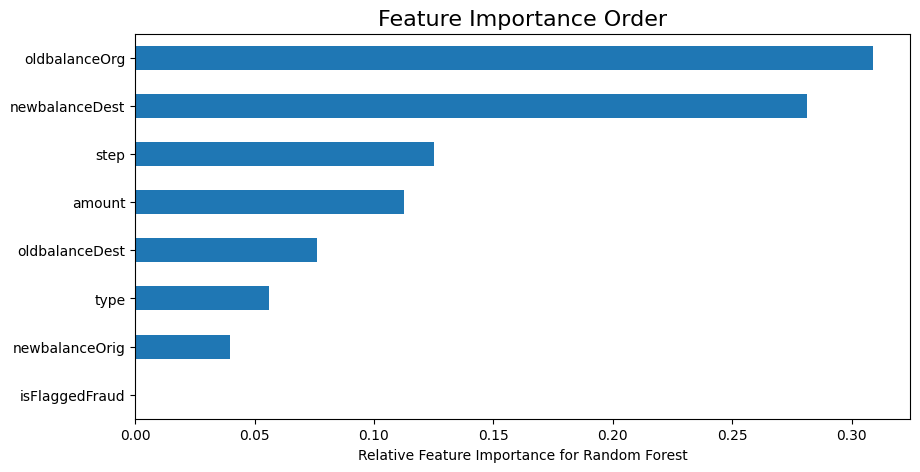

In [85]:
# plot the important features - based on Random Forest
feat_importances = pd.Series(rf_model.feature_importances_, index=features.columns)
ax.set_ylabel('features', size = 16);
feat_importances.nlargest(10).sort_values().plot(kind='barh', figsize=(10,5))
plt.xlabel('Relative Feature Importance for Random Forest');
plt.title('Feature Importance Order', size = 16);

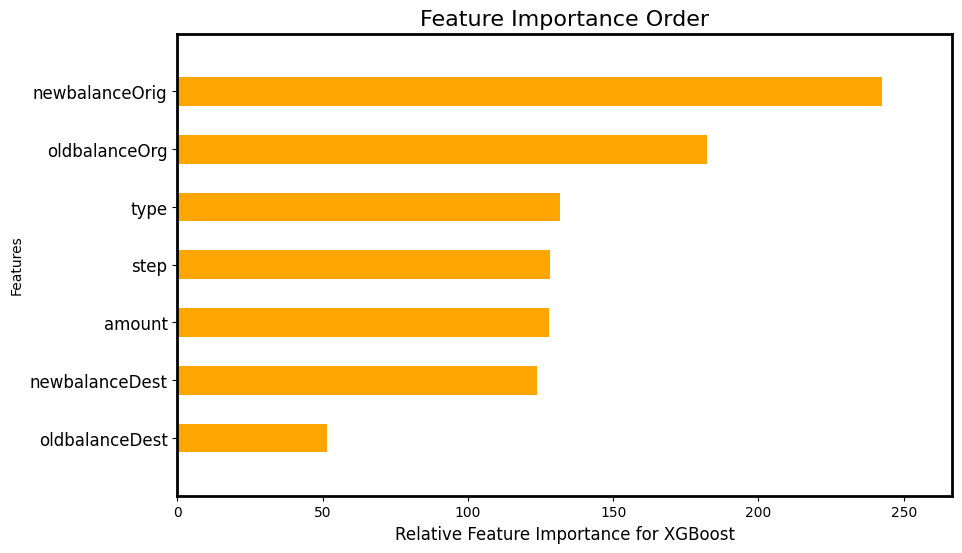

In [86]:
# plot the important features - based on XGBOOST
from xgboost import plot_importance

fig = plt.figure(figsize = (10, 6))
ax = fig.add_subplot(111)
colours = plt.cm.Set1(np.linspace(0, 1, 9))
ax = plot_importance(xgb_model, height = 0.5, color = 'orange', grid = False, \
                     show_values = False, importance_type = 'cover', ax = ax);
for axis in ['top','bottom','left','right']:
            ax.spines[axis].set_linewidth(2)        
ax.set_xlabel('Relative Feature Importance for XGBoost', size=12);
ax.set_yticklabels(ax.get_yticklabels(), size = 12);
ax.set_title('Feature Importance Order', size = 16);

Each model gives different importance to the features. But oldbalanceOrg and newbalanceDest are the major indicators for both models.

## 6. Conclusion

### Accuracy results after iterations

I created a model that can predict fraud transactions. I used XGBoost and RandomForest classifiers in this model.

### Model Performance Summary

| Iteration | Data & Parameters                                      | XGBoost Accuracy | RandomForest Accuracy |
|-----------|--------------------------------------------------------|----------------|--------------------|
| 1         | Random Sample & default parameters                     | 87%            | 86%                |
| 2         | Random Sample & best parameters                        | 99.5%          | 84.3%              |
| 3         | Balanced data with SMOTE & best parameters             | 99.4%          | 98.7%              |
| 4         | Random Safe transactions & all Fraud data & best params| 98.8%          | 99.6%              |
| 5         | New data balanced with SMOTE & best parameters         | 99%            | 92.1%              |

**Observation:**  
Performance improved across iterations. XGBoost performed well on most datasets, while Random Forest excelled when data was highly balanced. After five iterations, the models reached near-optimal accuracy for fraud detection.
